# HANK-SAM

**Table of contents**<a id='toc0_'></a>    
- 1. [Steady state](#toc1_)    
  - 1.1. [Policy functions](#toc1_1_)    
  - 1.2. [Distribution](#toc1_2_)    
  - 1.3. [Spending in unemployment](#toc1_3_)    
- 2. [Effect of government spending](#toc2_)    
  - 2.1. [Tests](#toc2_1_)    
  - 2.2. [Jacobians](#toc2_2_)    
  - 2.3. [Response](#toc2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

This notebook shows how to **solve a Heterogenous Agent New Keynessian (HANK) model with a search-and-match (SAM) labor market** using the ``GEModelTools`` package.

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import scipy.optimize as optimize
from types import SimpleNamespace

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKSAMModel import HANKSAMModelClass

In [2]:
def create_fig(figsize=(6,6/1.5)):
    
    fig = plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_subplot(1,1,1)

    return fig,ax

def format_fig(fig,ax,ylabel='',T_max=48,legend=True):

    if legend: ax.legend(frameon=True)
    ax.set_xlabel('months')
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(T_max+1)[::12])
    ax.set_xlim([0,T_max]);
    
    fig.tight_layout()

## 1. <a id='toc1_'></a>[Steady state](#toc0_)

In [3]:
model = HANKSAMModelClass(name='baseline')

In [4]:
par = model.par
ss = model.ss
path = model.path

ss.u_bar = 6.0

In [5]:
model.find_ss(do_print=True)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 4.3 secs [4082 iterations]
household problem in ss simulated in 1.3 secs [1959 iterations]
ss.G = 0.4226
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
steady state found in 5.8 secs


In [6]:
try:
    model.test_ss()
except:
    print('newer version of GEModelTools needed')

w              :       0.7500
TFP            :       1.0000
px             :       0.8333
delta          :       0.0200
Vj             :       3.7766
errors_Vj      :       0.0000
v              :       0.0375
S              :       0.0625
u              :       0.0625
theta          :       0.6000
lambda_v       :       0.5000
lambda_u_s     :       0.3000
errors_u       :       0.0000
errors_Vv      :       0.0000
pi             :       0.0000
errors_pi      :       0.0000
i              :       0.0017
div            :       0.2344
q              :      33.9797
r              :       0.0017
G              :       0.4226
U_UI_hh_guess  :       0.0551
Phi            :       0.0312
transfer       :      -0.2344
X              :       0.2194
taut           :       0.3000
tau            :       0.3000
taxes          :       0.2203
B              :       0.0161
u_bar          :       6.0000
A_hh           :       0.5482
C_hh           :       0.5149
U_ALL_hh       :       0.0625
U_UI_hh   

### 1.1. <a id='toc1_1_'></a>[Policy functions](#toc0_)

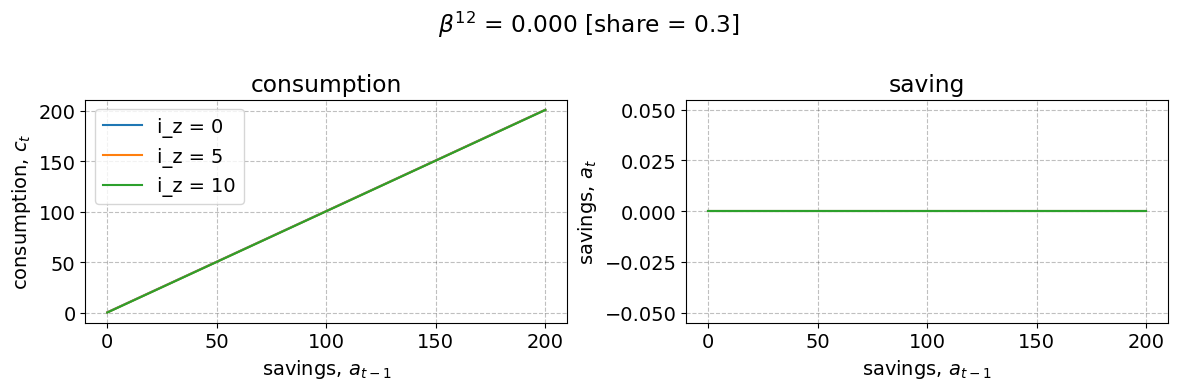

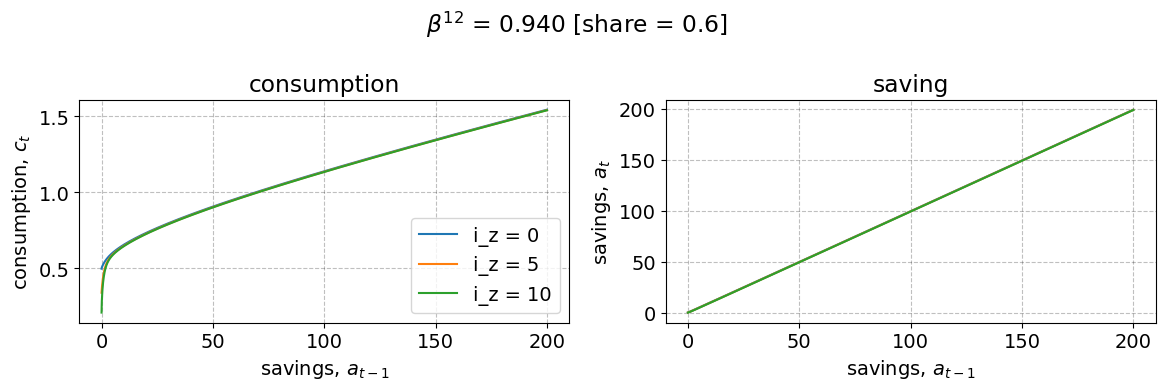

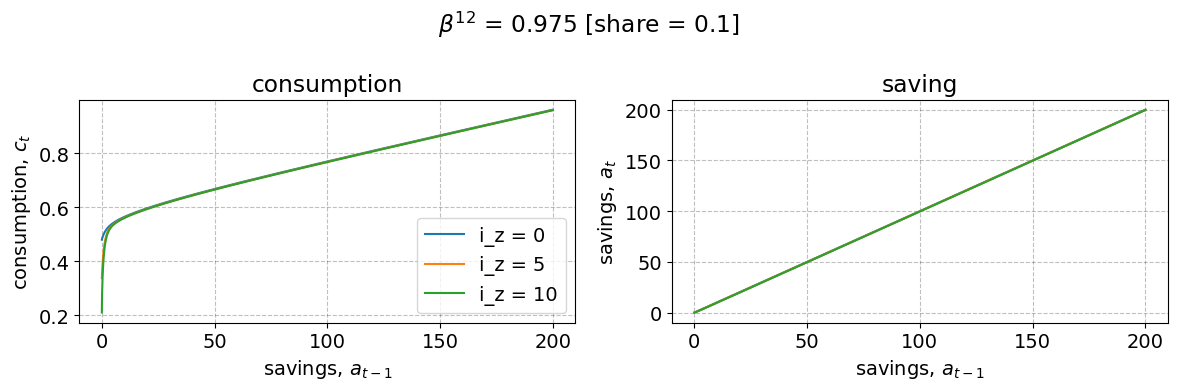

In [7]:
for i_fix in range(par.Nfix):

    fig = plt.figure(figsize=(12,4),dpi=100)
    a_max = 500

    # a. consumption
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,2,1)
    ax.set_title(f'consumption')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.legend(frameon=True)
    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('consumption, $c_t$')

    # b. saving
    I = par.a_grid < a_max

    ax = fig.add_subplot(1,2,2)
    ax.set_title(f'saving')

    for i_z in [0,par.Nz//2,par.Nz-1]:
        ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

    ax.set_xlabel('savings, $a_{t-1}$')
    ax.set_ylabel('savings, $a_{t}$')

    fig.suptitle(fr'$\beta^{{12}}$ = {par.beta_grid[i_fix]**12:.3f} [share = {par.beta_shares[i_fix]}]')
    fig.tight_layout()

### 1.2. <a id='toc1_2_'></a>[Distribution](#toc0_)

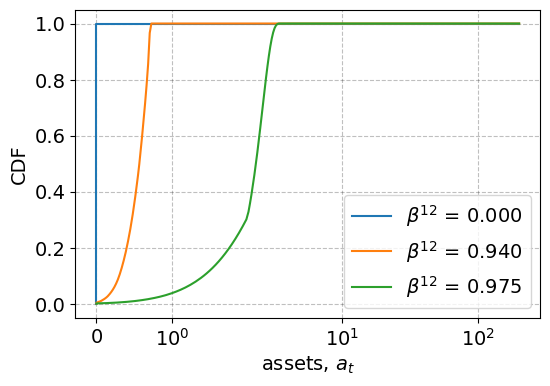

In [8]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)

for i_fix in range(par.Nfix):
    y = np.insert(np.cumsum(np.sum(ss.D[i_fix],axis=0)),0,0.0)
    ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1],
            label=f'$\\beta^{{12}}$ = {par.beta_grid[i_fix]**12:.3f}')
        
ax.legend(frameon=True)
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')


### 1.3. <a id='toc1_3_'></a>[Spending in unemployment](#toc0_)

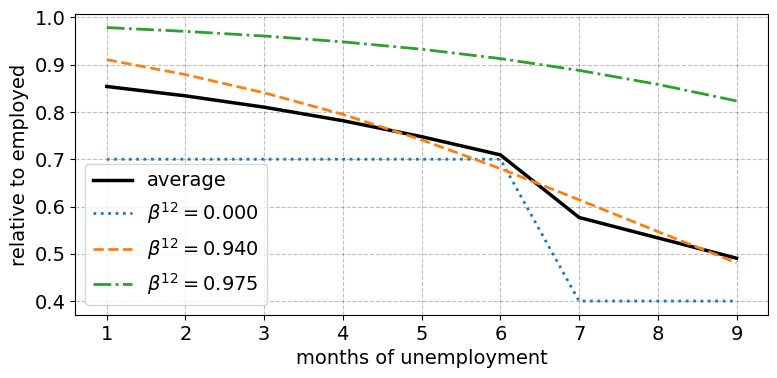

In [9]:
fig,ax = create_fig(figsize=(8,6/1.5))  

# baseline
C_e,C_u,C_u_dur = model.calc_Cs()
ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,ls='-',lw=2.5,color='black',label='average')

for i_fix,ls in zip(range(par.Nfix),[':','--','-.']):
    C_e,C_u,C_u_dur = model.calc_Cs(i_fix=i_fix)
    ax.plot(np.arange(1,par.Nu),C_u_dur[:-1]/C_e,lw=2,ls=ls,label=f'$\\beta^{{12}} = {par.beta_grid[i_fix]**12:.3f}$')

# details
ax.set_xticks(np.arange(1,par.Nu));
ax.set_xlabel('months of unemployment')
ax.set_ylabel('relative to employed')
ax.legend(frameon=True,ncol=1)

fig.tight_layout()

In [10]:
C_e,C_u,C_u_dur = model.calc_Cs()
C_drop_ss = (C_u/C_e-1)*100
C_drop_ex = (C_u_dur[6]-C_u_dur[5])/((1-ss.tau)*(par.phi_obar-par.phi_ubar)*ss.w)*100
print(f'{C_drop_ss = :.2f}')
print(f'{C_drop_ex = :.2f}')

C_drop_ss = -22.01
C_drop_ex = -43.90


## 2. <a id='toc2_'></a>[Effect of government spending](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Tests](#toc0_)

In [11]:
model.test_path()

shocks: G u_bar 
unknowns: px Vj v u S pi U_UI_hh_guess 

look at max(abs(path.VARNAME[:]-ss.VARNAME)):

 blocks.production
  w                0.0e+00
  TFP              0.0e+00
  delta            0.0e+00
  errors_Vj        0.0e+00 [target]
 blocks.labor_market
  theta            0.0e+00
  lambda_v         0.0e+00
  lambda_u_s       0.0e+00
  errors_u         0.0e+00 [target]
 blocks.entry
  errors_Vv        0.0e+00 [target]
 blocks.price_setters
  errors_pi        0.0e+00 [target]
 blocks.central_bank
  i                0.0e+00
 blocks.dividends
  div              0.0e+00
 blocks.financial_market
  q                0.0e+00
  r                2.2e-16
 blocks.government
  Phi              0.0e+00
  transfer         0.0e+00
  X                0.0e+00
  taut             0.0e+00
  tau              0.0e+00
  taxes            0.0e+00
  B                0.0e+00
 hh
  A_hh             7.9e-10
  C_hh             9.0e-12
  U_ALL_hh         8.3e-17
  U_UI_hh          7.6e-17
 blocks.market_cleari

### 2.2. <a id='toc2_2_'></a>[Jacobians](#toc0_)

In [12]:
model.compute_jacs(do_print=False,skip_shocks=True)

### 2.3. <a id='toc2_3_'></a>[Response](#toc0_)

In [13]:
# creating models with different jump sizes
modelI = model.copy()
modelI.par.jump_G = par.jump_G*2
modelII = model.copy()
modelII.par.jump_G = par.jump_G*4

# finding transition paths
model.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)
modelI.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)
modelII.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

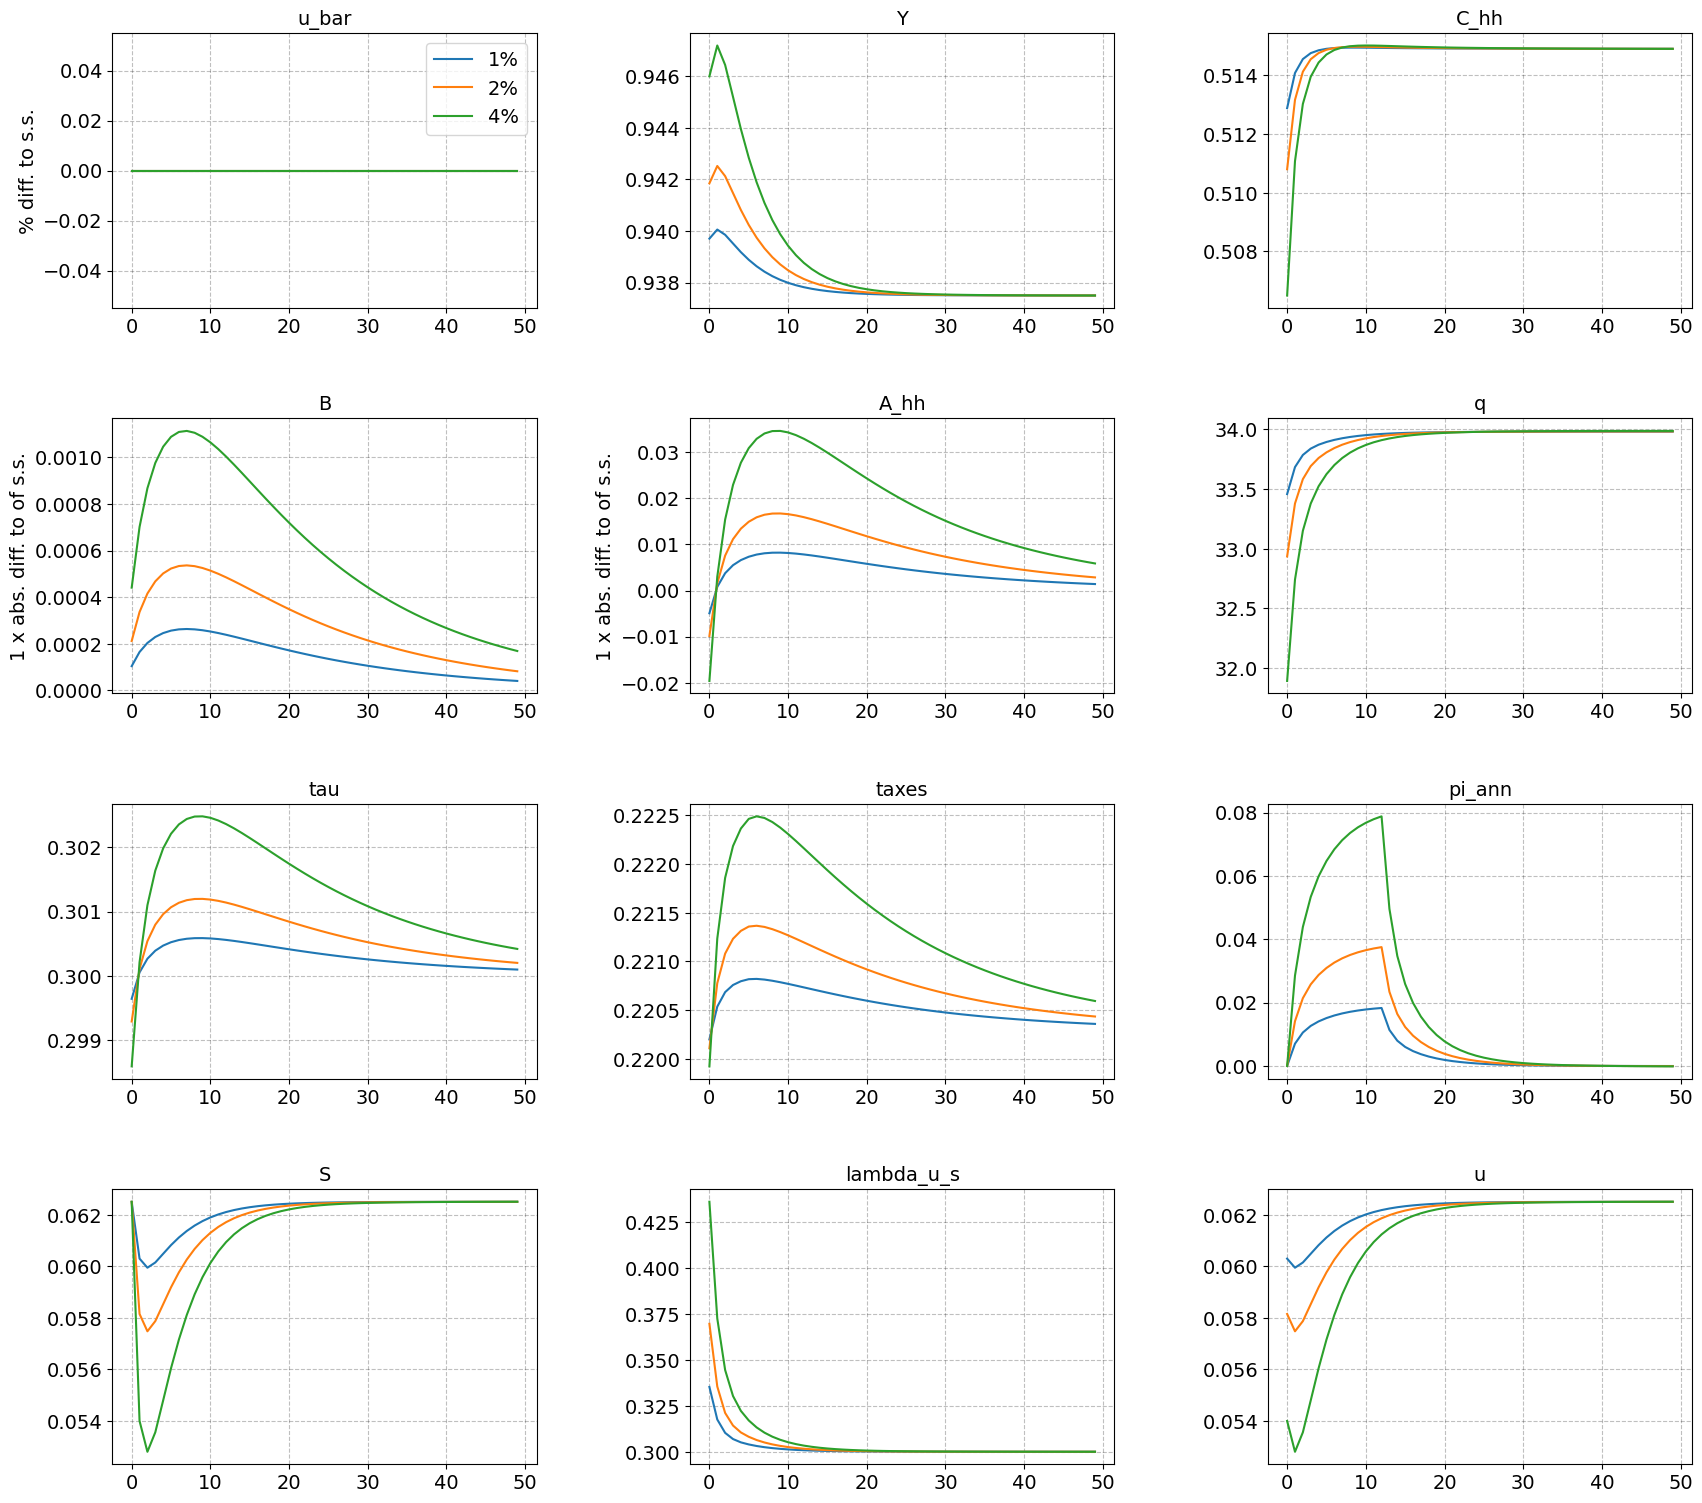

In [14]:
paths = ['u_bar','Y','C_hh','B','A_hh','q','tau','taxes','pi_ann','S','lambda_u_s','u']
abs_diff = ['B','A_hh']
lvl_value = ['Y','C_hh','q','tau','taxes','pi_ann','u','lambda_u_s','S']

model.compare_IRFs(models=[model, modelI, modelII],labels=['1%','2%','4%'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G')

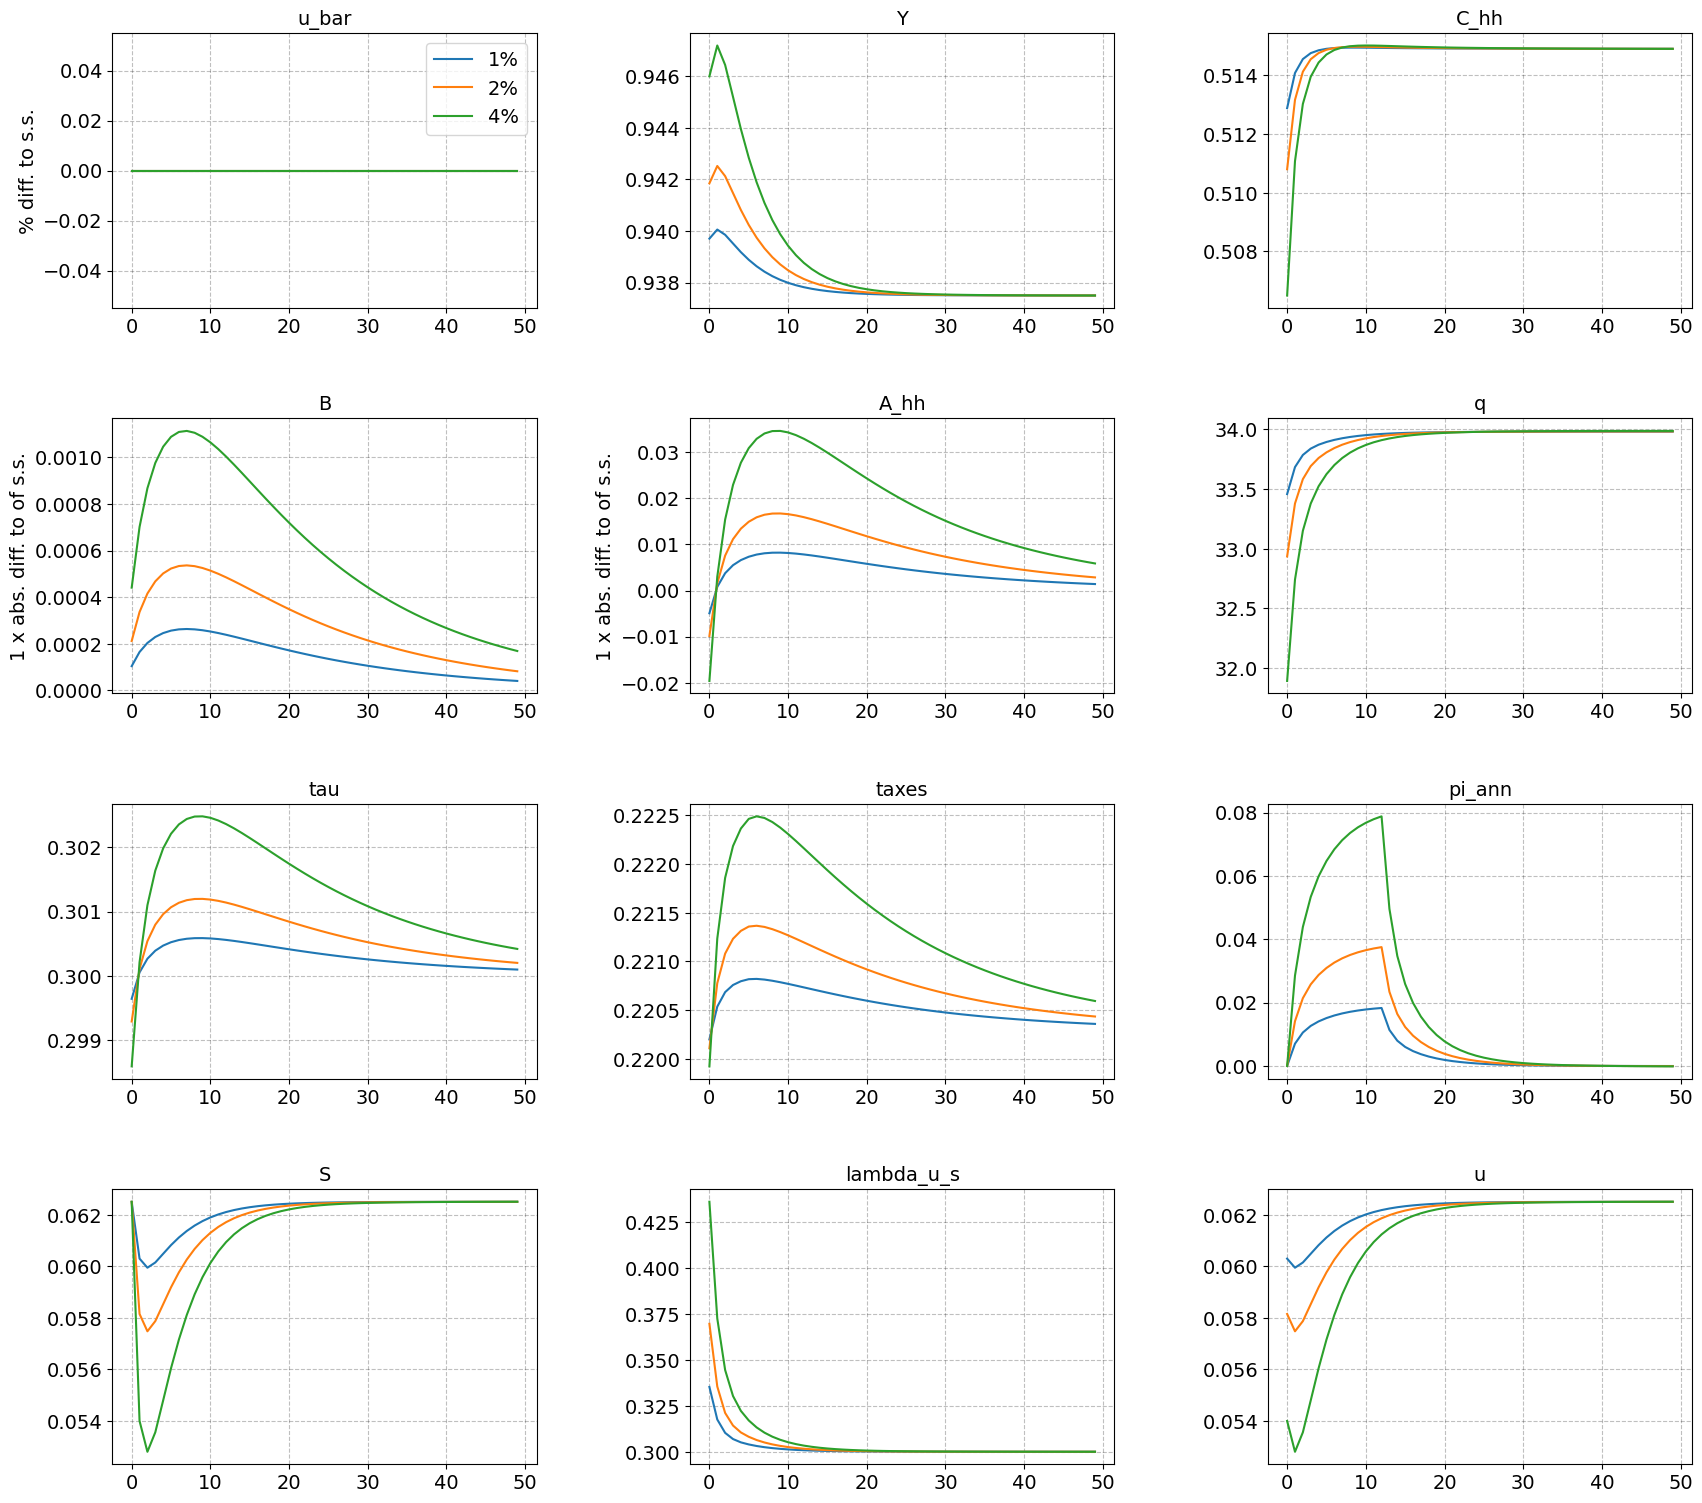

In [15]:
paths = ['u_bar','Y','C_hh','B','A_hh','q','tau','taxes','pi_ann','S','lambda_u_s','u']
abs_diff = ['B','A_hh']
lvl_value = ['Y','C_hh','q','tau','taxes','pi_ann','u','lambda_u_s','S']

model.compare_IRFs(models=[model, modelI, modelII],labels=['1%','2%','4%'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G')

### Fiscal Multiplier

In [16]:
model.fiscal_multiplier()
model.fiscal_multiplier(type='C_hh')

multiplier = 1.2709
multiplier = -0.2187


-0.21872241481599602

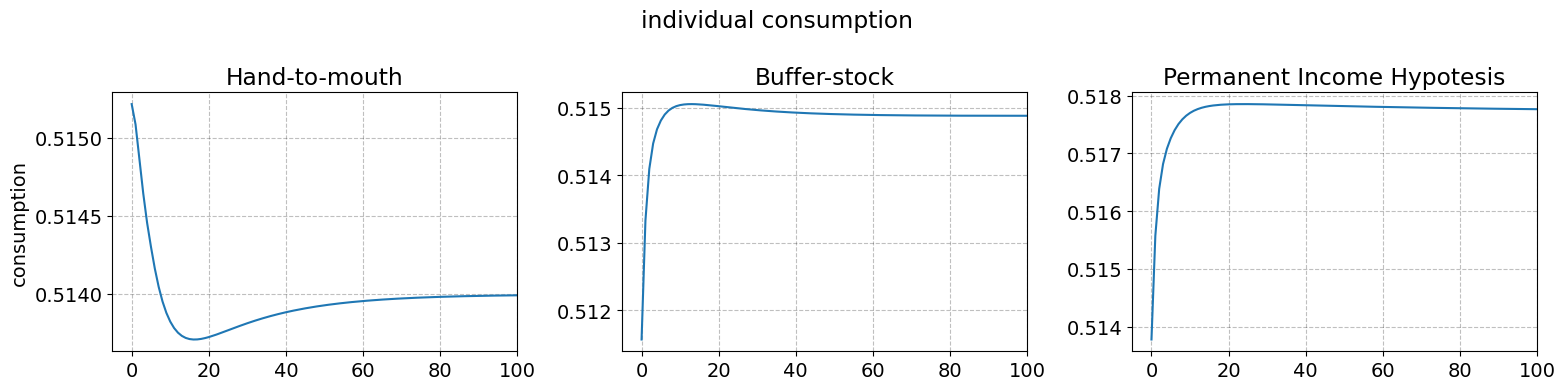

In [17]:
individual_c = np.sum((path.c)*path.D, axis=(-1,-2))/np.sum(path.D, axis=(-1,-2))

# Assume summed_array is your array of shape (480, 3)
fig, axs = plt.subplots(1, 3, figsize=(16, 4), dpi=100)
# Create a new figure

names = ['Hand-to-mouth', 'Buffer-stock', 'Permanent Income Hypotesis']

# Loop over the columns of the array
for i, name in enumerate(names):
    # Create a subplot for the i-th column
    plt.subplot(1, 3, i+1)
    # Plot the i-th column with the corresponding name as label
    plt.plot(individual_c[:, i])
    # Add a legend
    axs[i].set_title(name)
    plt.xlim([-5, 100])
    if i == 0:
        axs[i].set_ylabel('consumption')

plt.suptitle('individual consumption')
plt.tight_layout()
plt.savefig('figures/individual_consumption.pdf')

In [18]:
# calculating difference in consumption from steady state
individual_ss = np.sum((ss.c)*path.D, axis=(-1,-2))/np.sum(path.D, axis=(-1,-2))
np.sum(individual_c[:,0]-individual_ss[:,0])

-0.00836827633607018

### Different value of $\omega$

In [19]:
modelIII = model.copy()
modelIII.par.omega = 0.25
modelIII.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

In [20]:
modelIII.fiscal_multiplier()

multiplier = 0.9776


0.9775804926518041

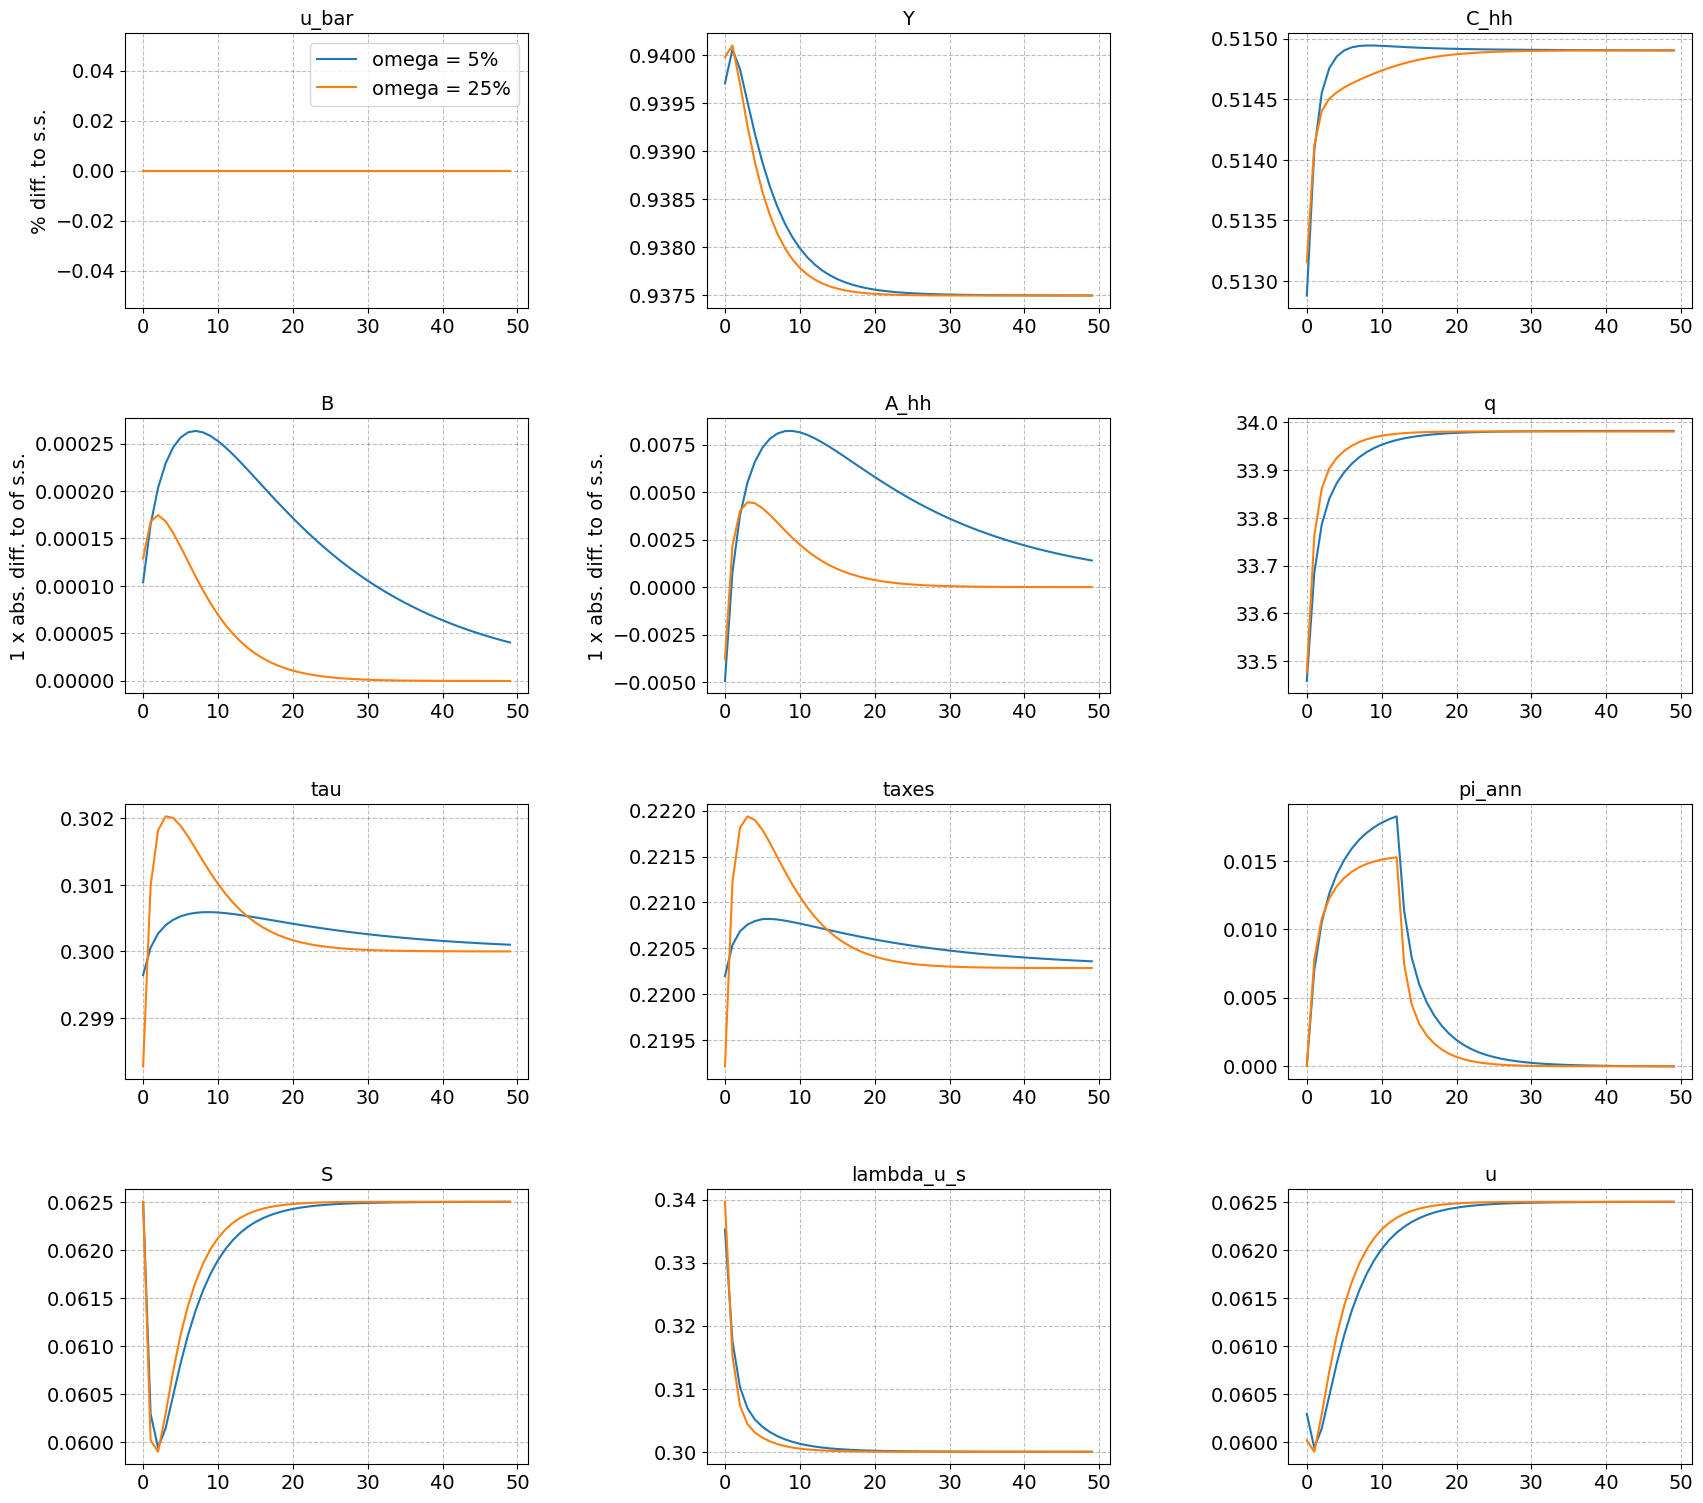

In [21]:
model.compare_IRFs(models=[model, modelIII],labels=['omega = 5%','omega = 25%'],varnames=paths,abs_diff=abs_diff, lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G_omega')

### Increase in share of HTM households

In [22]:
modelIV = model.copy()
modelIV.par.HtM_share = 0.80

modelIV.find_ss(do_print=True)
modelIV.compute_jacs(do_print=False,skip_shocks=True)
modelIV.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 2.9 secs [4082 iterations]
household problem in ss simulated in 0.2 secs [1959 iterations]
ss.G = 0.4230
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
steady state found in 3.1 secs


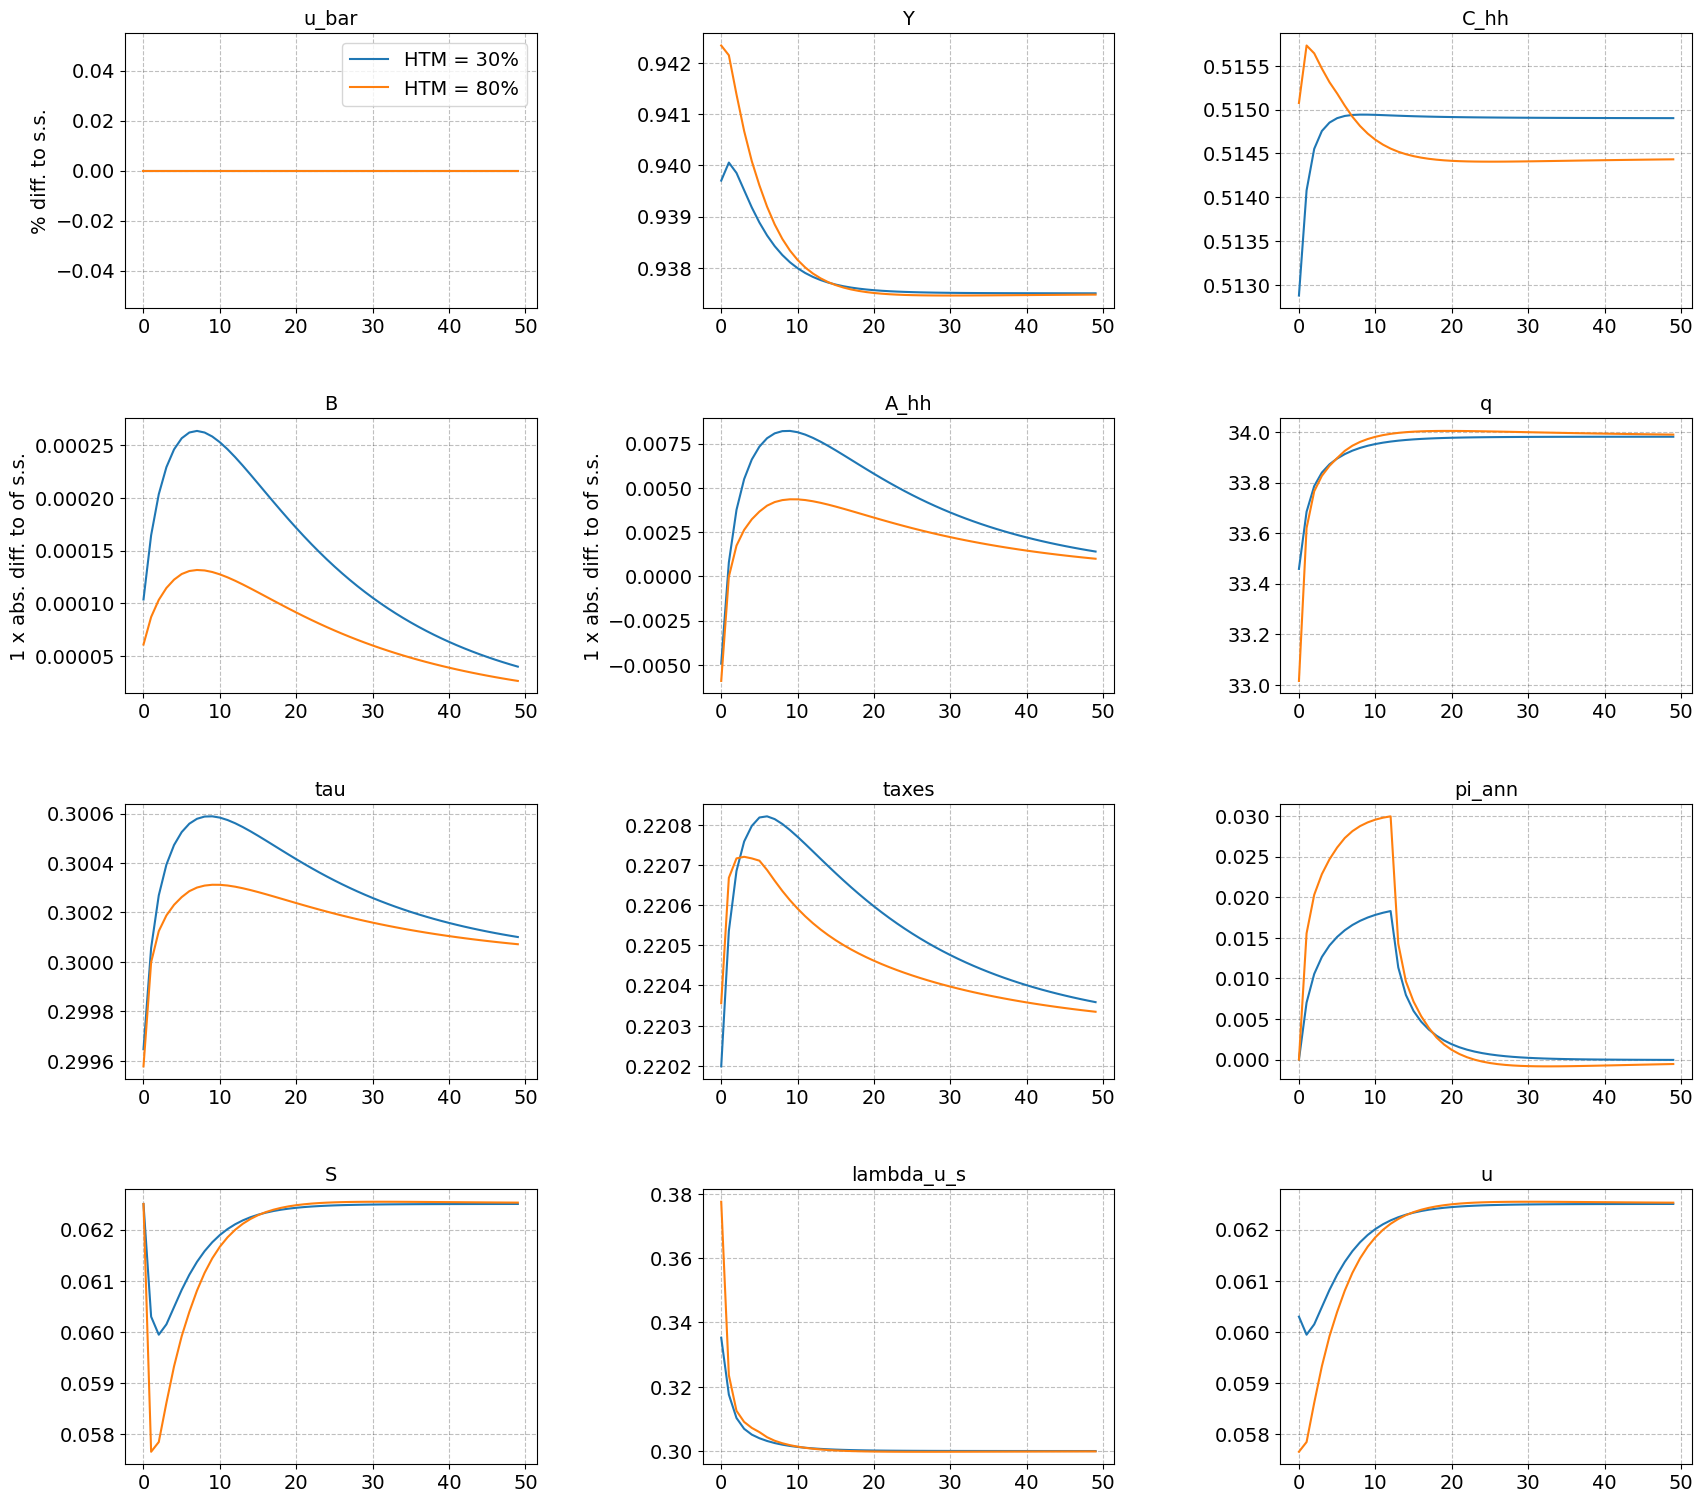

In [23]:
model.compare_IRFs(models=[model, modelIV],labels=['HTM = 30%','HTM = 80%'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G_HTM')

In [24]:
modelIV.fiscal_multiplier()

multiplier = 2.7391


2.739088480296402

### RANKSAM


In [25]:
modelRA = model.copy()

modelRA.par.HtM_share = 0.0
modelRA.par.PIH_share = 0.0

modelRA.par.beta_BS = 1/(1+modelRA.par.r_ss)


### Unemployment insurance duration

In [26]:
modelV = model.copy()
modelV.ss.u_bar = 7.0

In [27]:
modelV.find_ss(do_print=True)
modelV.compute_jacs(do_print=False,skip_shocks=True)
modelV.find_transition_path(shocks=['G'],do_print=False,do_end_check=False)

par.A = 0.3680
par.kappa = 1.8883
ss.w = 0.7500
ss.delta = 0.0200
ss.lambda_u_s = 0.3000
ss.lambda_v = 0.5000
ss.theta = 0.6000
ss.u = 0.0625
ss.S = 0.0625
household problem in ss solved in 2.8 secs [4068 iterations]
household problem in ss simulated in 0.2 secs [1929 iterations]
ss.G = 0.4224
ss.clearing_Y = 0.0000
par.jump_G = 0.0042
steady state found in 3.0 secs


In [28]:
modelV.fiscal_multiplier()

multiplier = 1.3205


1.3204832070854688

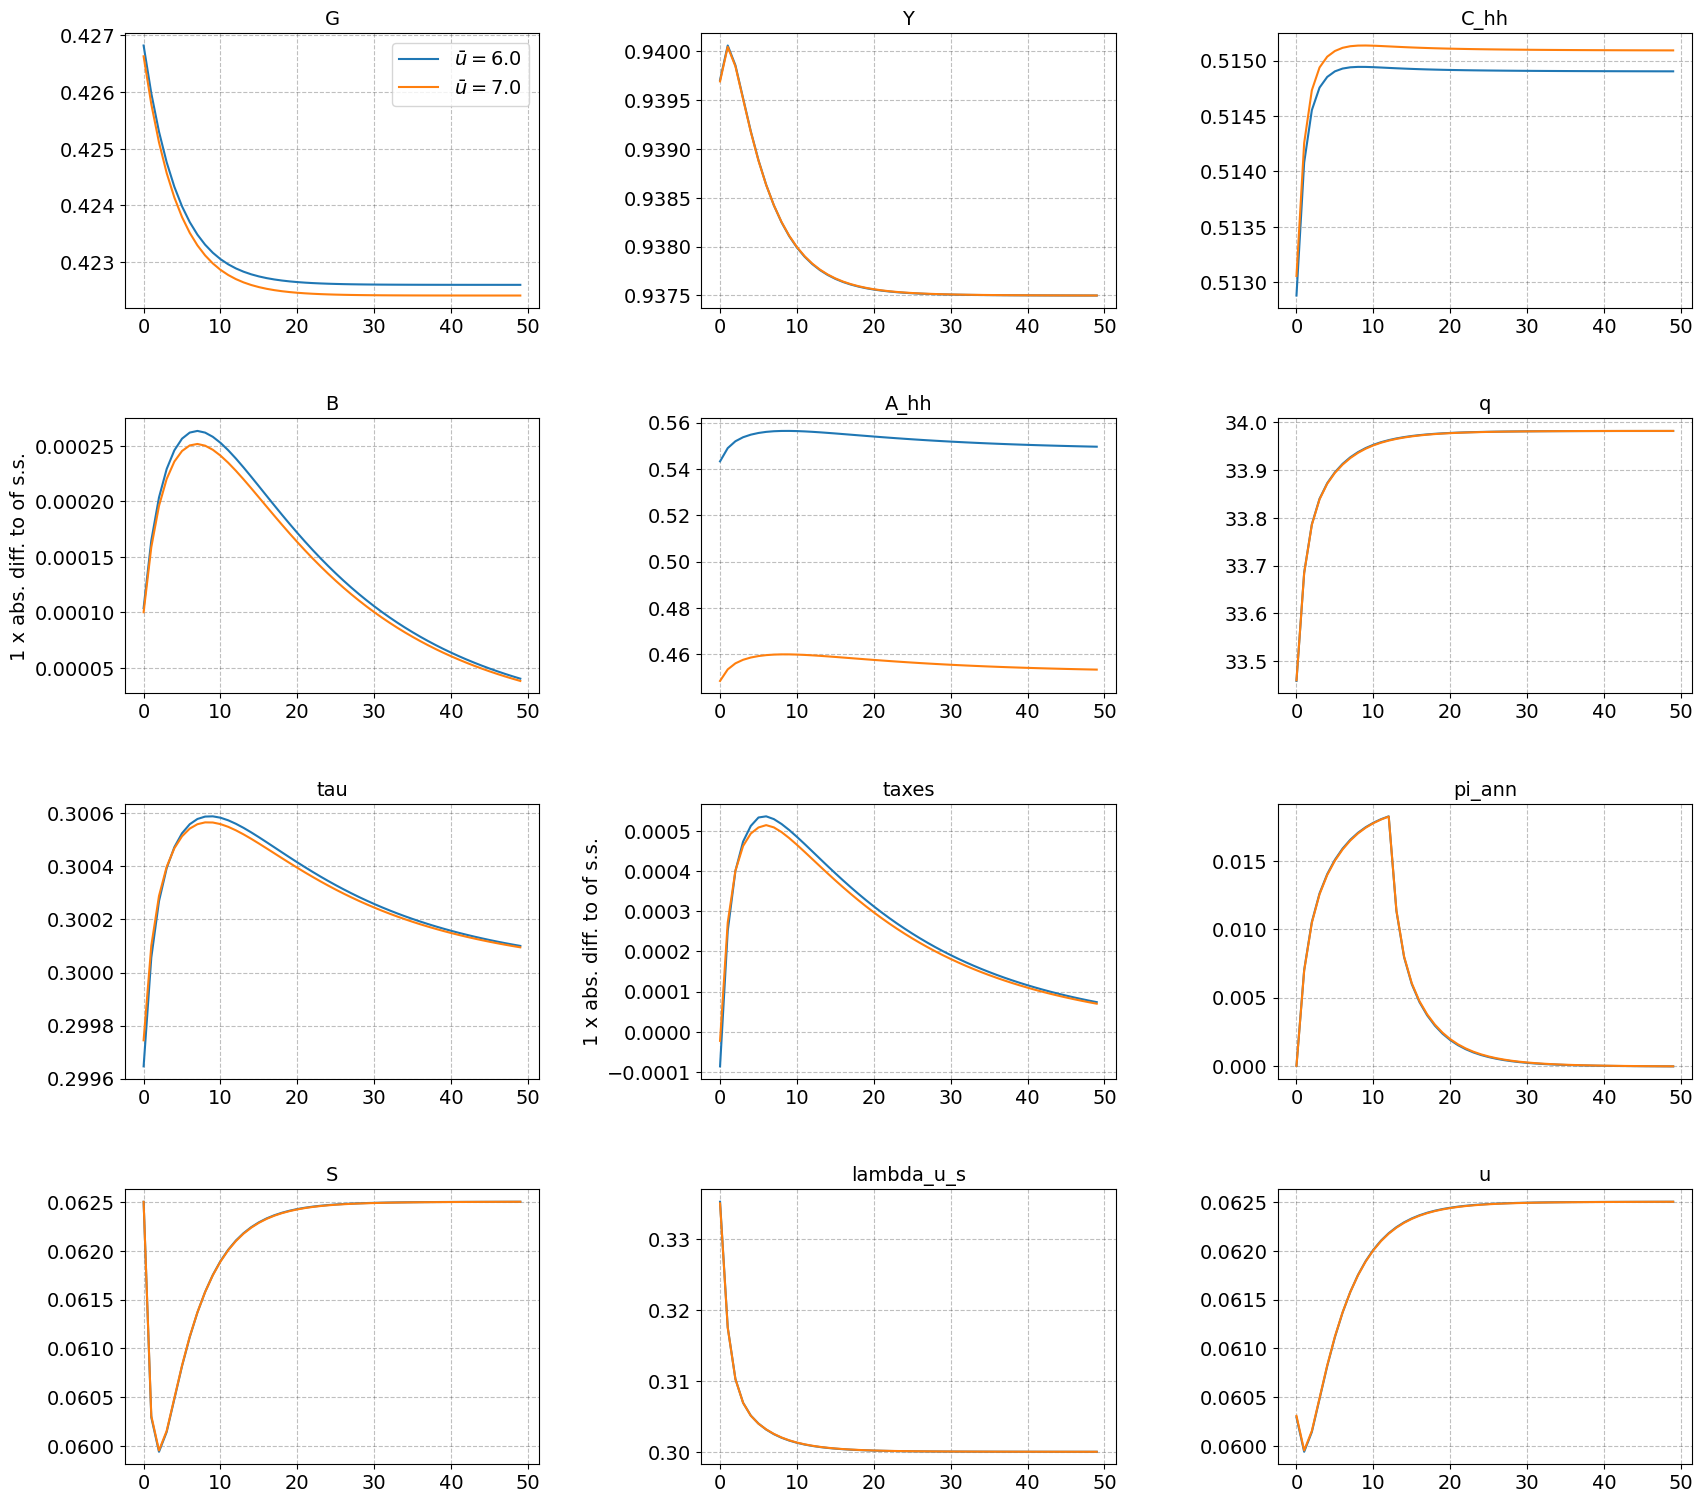

In [29]:
paths = ['G','Y','C_hh','B','A_hh','q','tau','taxes','pi_ann','S','lambda_u_s','u']
abs_diff = ['taxes','B']
lvl_value = ['G','Y','C_hh','q','tau','pi_ann','u','lambda_u_s','S','A_hh']
model.compare_IRFs(models=[model, modelV],labels=['$\\bar{u} = 6.0$','$\\bar{u} = 7.0$'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_G_u_bar')

### Shock 1 month in 12 months

In [30]:
modelVI = model.copy()

du_bar = np.zeros(par.T)
du_bar[:12] = 1.0

shocks = {'du_bar':du_bar} 


In [31]:
modelVI.find_transition_path(shocks=shocks,do_print=False,do_end_check=False)

In [32]:
modelVI.fiscal_multiplier()

multiplier = 1.4798


1.4797989628595145

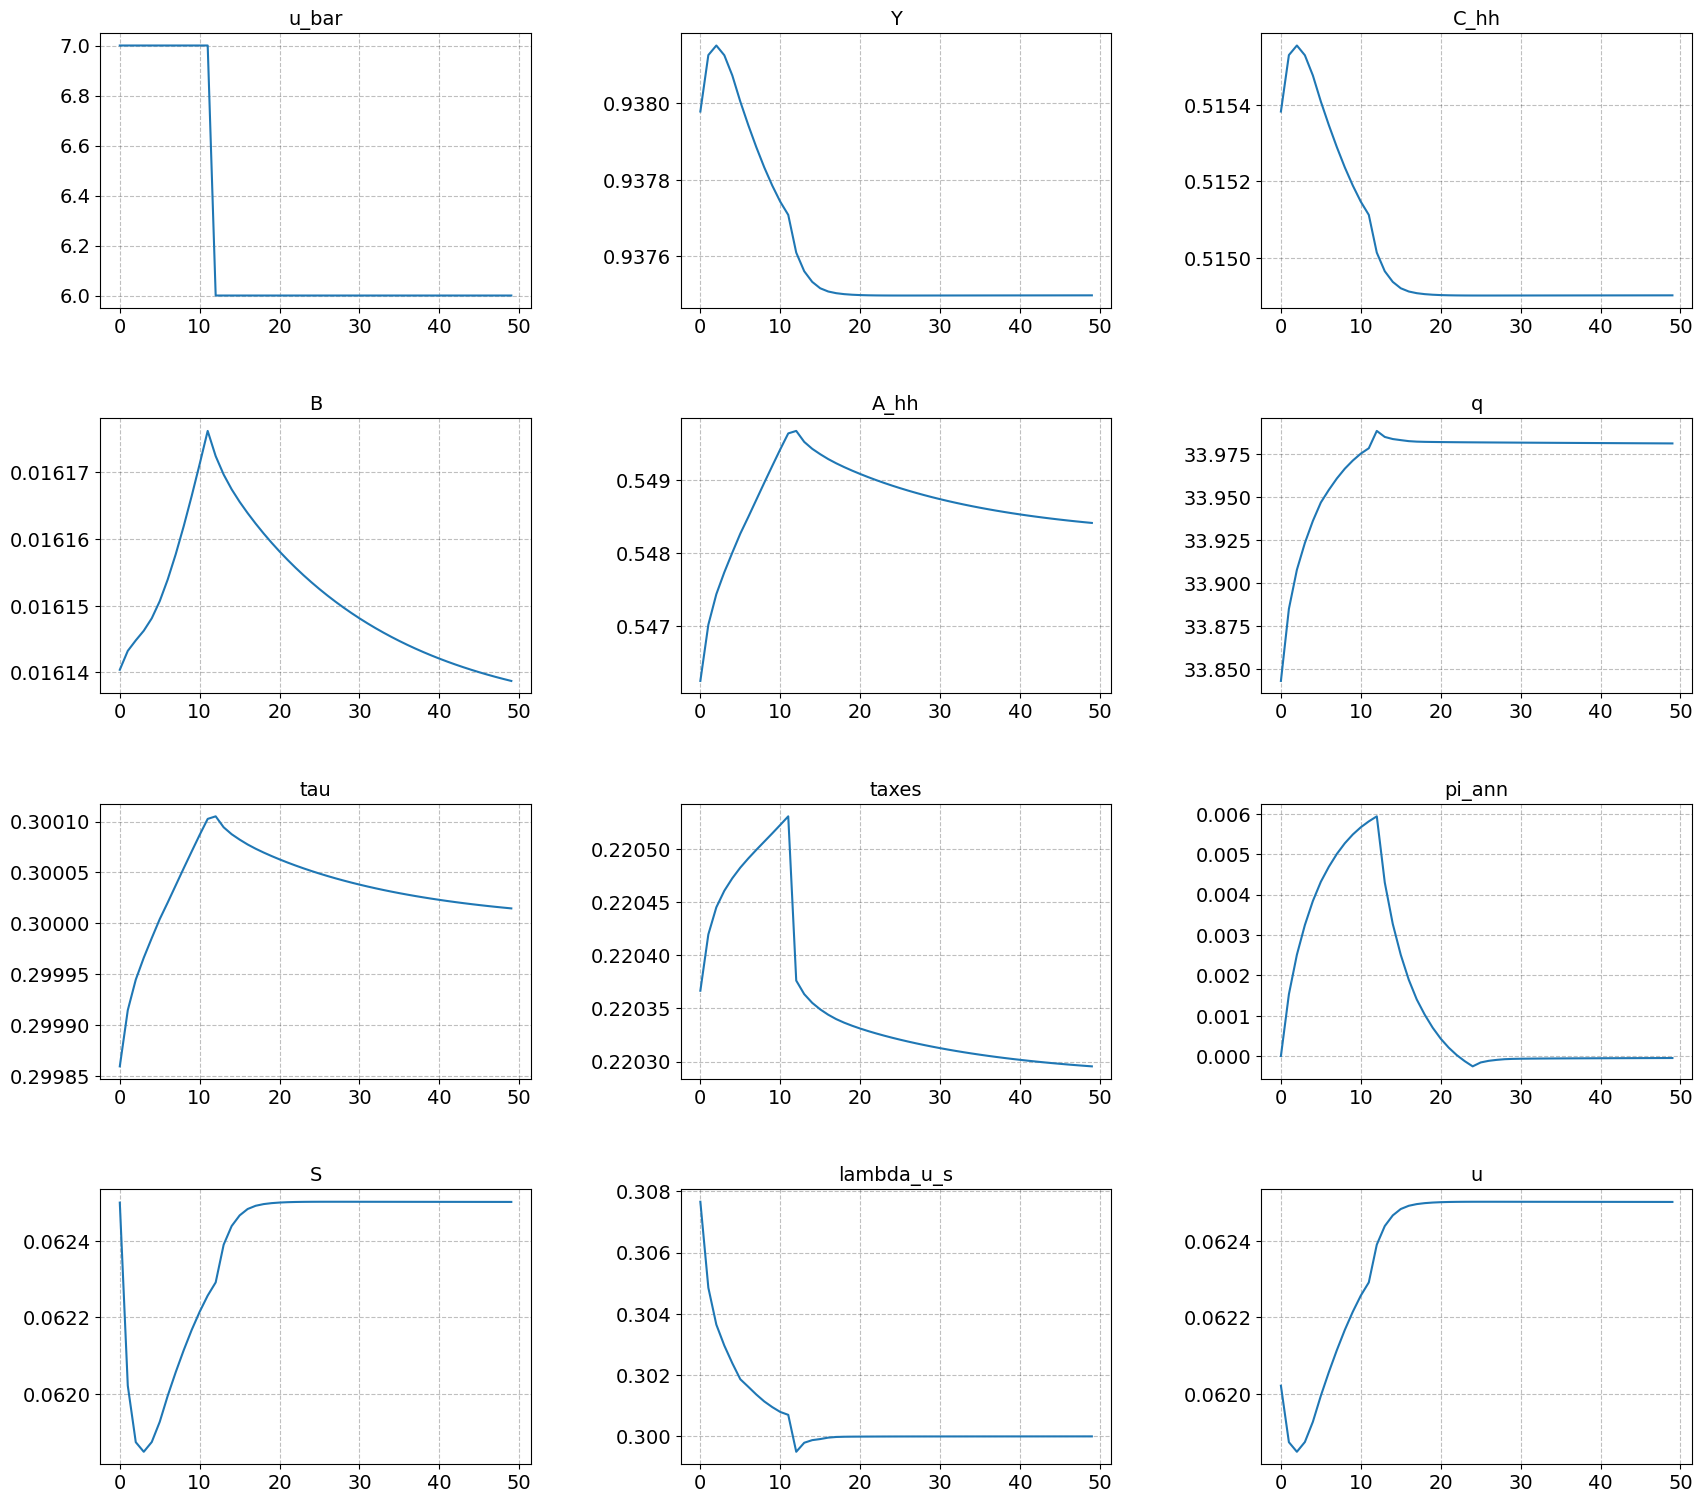

In [33]:
paths = ['u_bar','Y','C_hh','B','A_hh','q','tau','taxes','pi_ann','S','lambda_u_s','u']
abs_diff = []
lvl_value = ['u_bar','Y','C_hh','q','B','A_hh','tau','taxes','i_ann','pi_ann','u','lambda_u_s','S']
modelVI.show_IRFs(varnames=paths,T_max=50,ncols=3, abs_diff=abs_diff,lvl_value=lvl_value,do_targets=False,do_shocks=False,filename='figures/IRFs_du_bar_0-12')

### Annouced shock

In [34]:
modelVII = model.copy()

du_bar = np.zeros(par.T)
du_bar[12:24] = 1.0

shocks = {'du_bar':du_bar} 
modelVII.find_transition_path(shocks=shocks,do_print=False,do_end_check=False)

In [35]:
modelVII.fiscal_multiplier()

multiplier = 5.1859


5.185859014108364

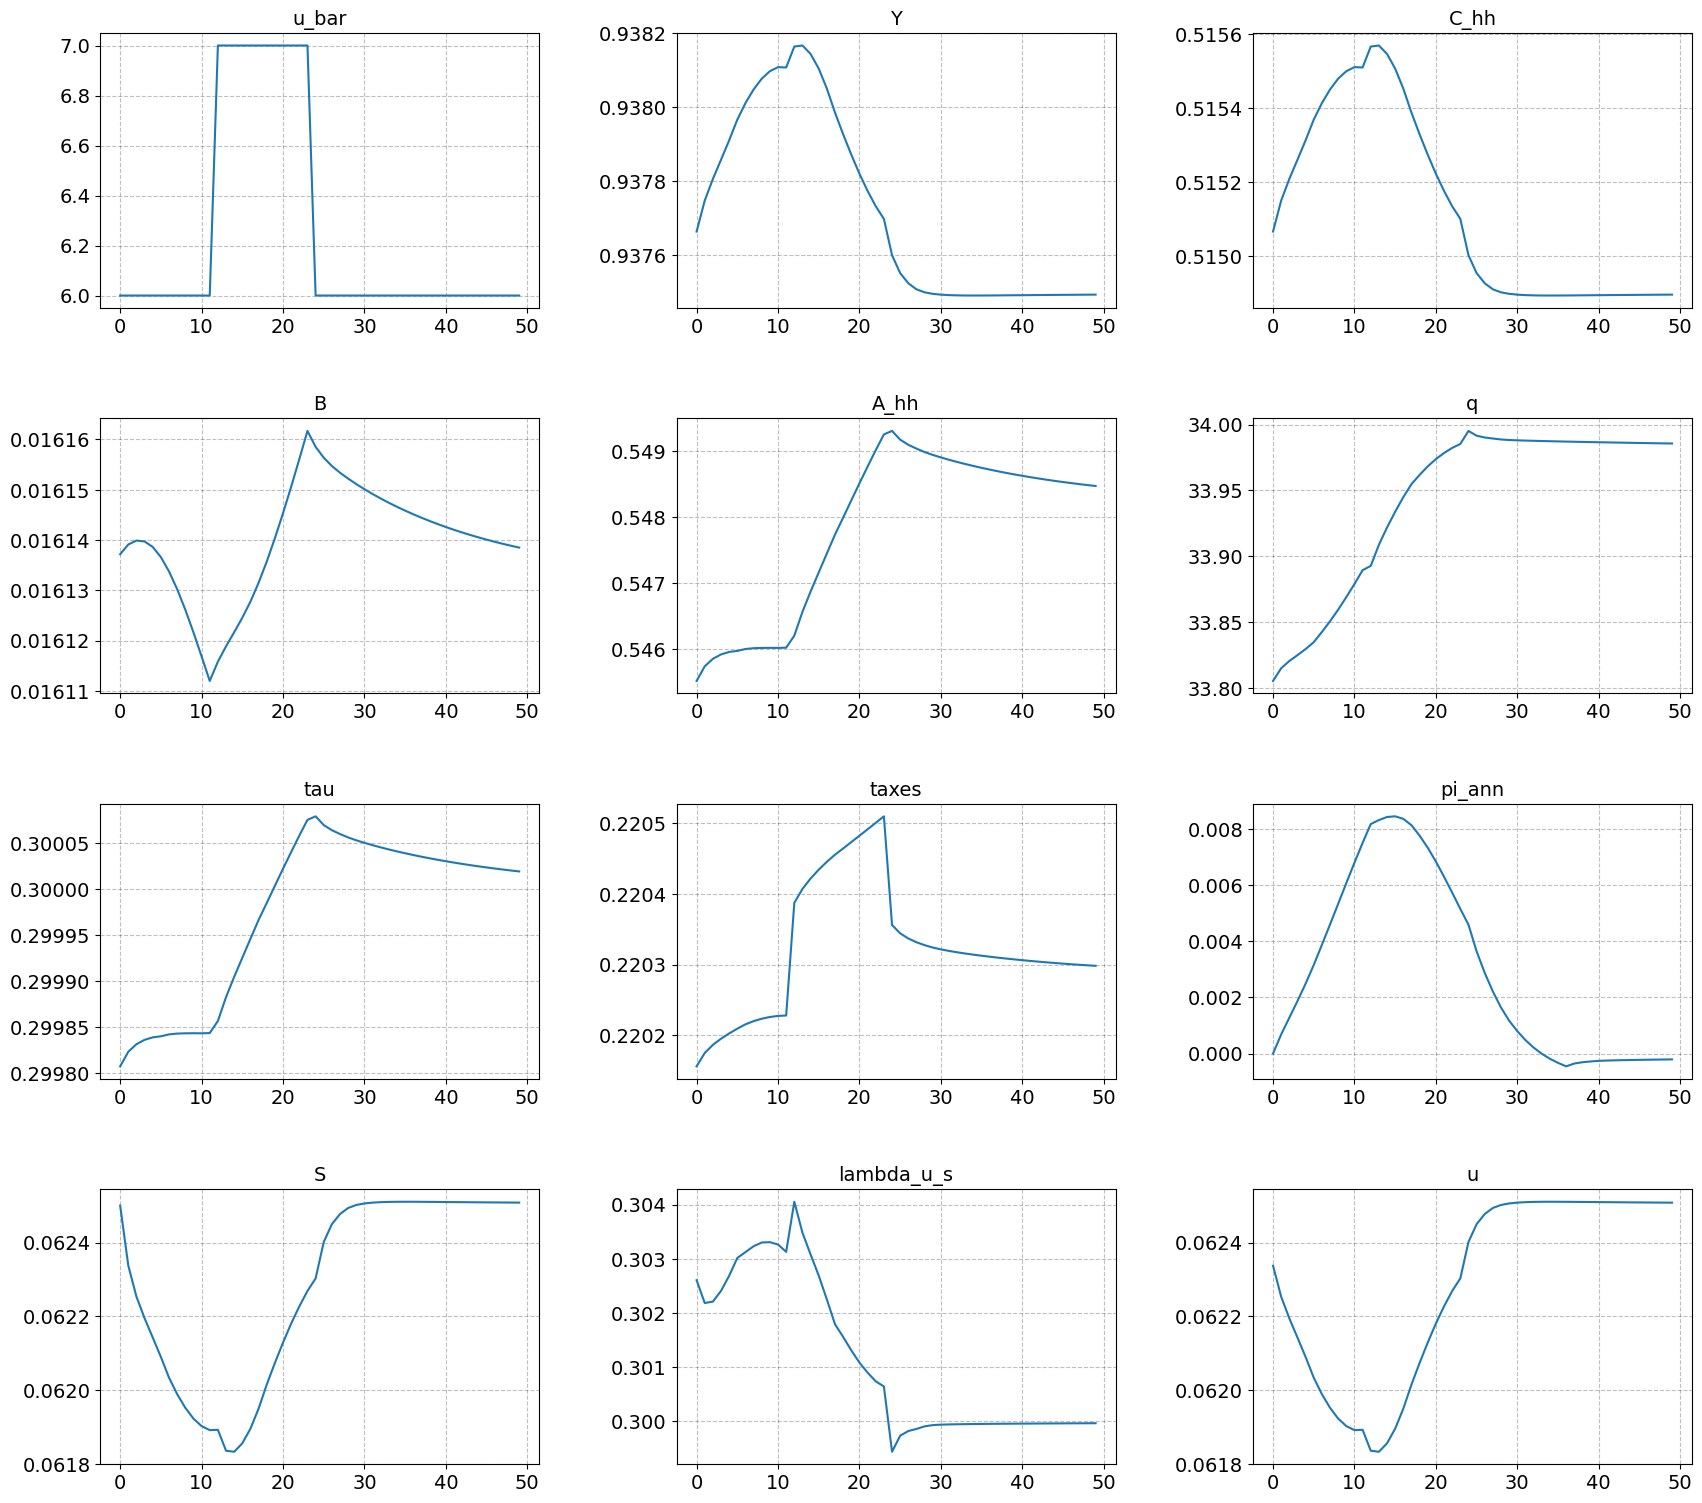

In [36]:
modelVII.show_IRFs(varnames=paths,T_max=50,ncols=3, abs_diff=abs_diff,lvl_value=lvl_value,do_targets=False,do_shocks=False,filename='figures/IRFs_du_bar_12-24')

### Lying about the shock

In [37]:
# creating a subset initial values for next transistion back to steady state
ini = SimpleNamespace()

# loop over all parameters in modelVII.path and create ini
for param in dir(modelVII.path):
    if not param.startswith('__'):
        ini.__dict__[param] = modelVII.path.__dict__[param][5:6]
        if ini.__dict__[param].size == 1:
            ini.__dict__[param] = ini.__dict__[param].item()

# change ini to dictionary
ini = vars(ini)

In [38]:
modelVIIb = model.copy()
modelVIIb.find_transition_path(shocks={},ini=ini,do_print=False,do_end_check=False)

In [39]:
# loop over all parameters in modelVIIb.path concate with the new 
for param in dir(modelVIIb.path):
    if not param.startswith('__'):
        # concatenate the new path with the old path
        modelVIIb.path.__dict__[param] = np.concatenate((modelVII.path.__dict__[param][:6],modelVIIb.path.__dict__[param][:474]))

In [40]:
modelVIIb.fiscal_multiplier()

multiplier = -3.7444


-3.7443620947474283

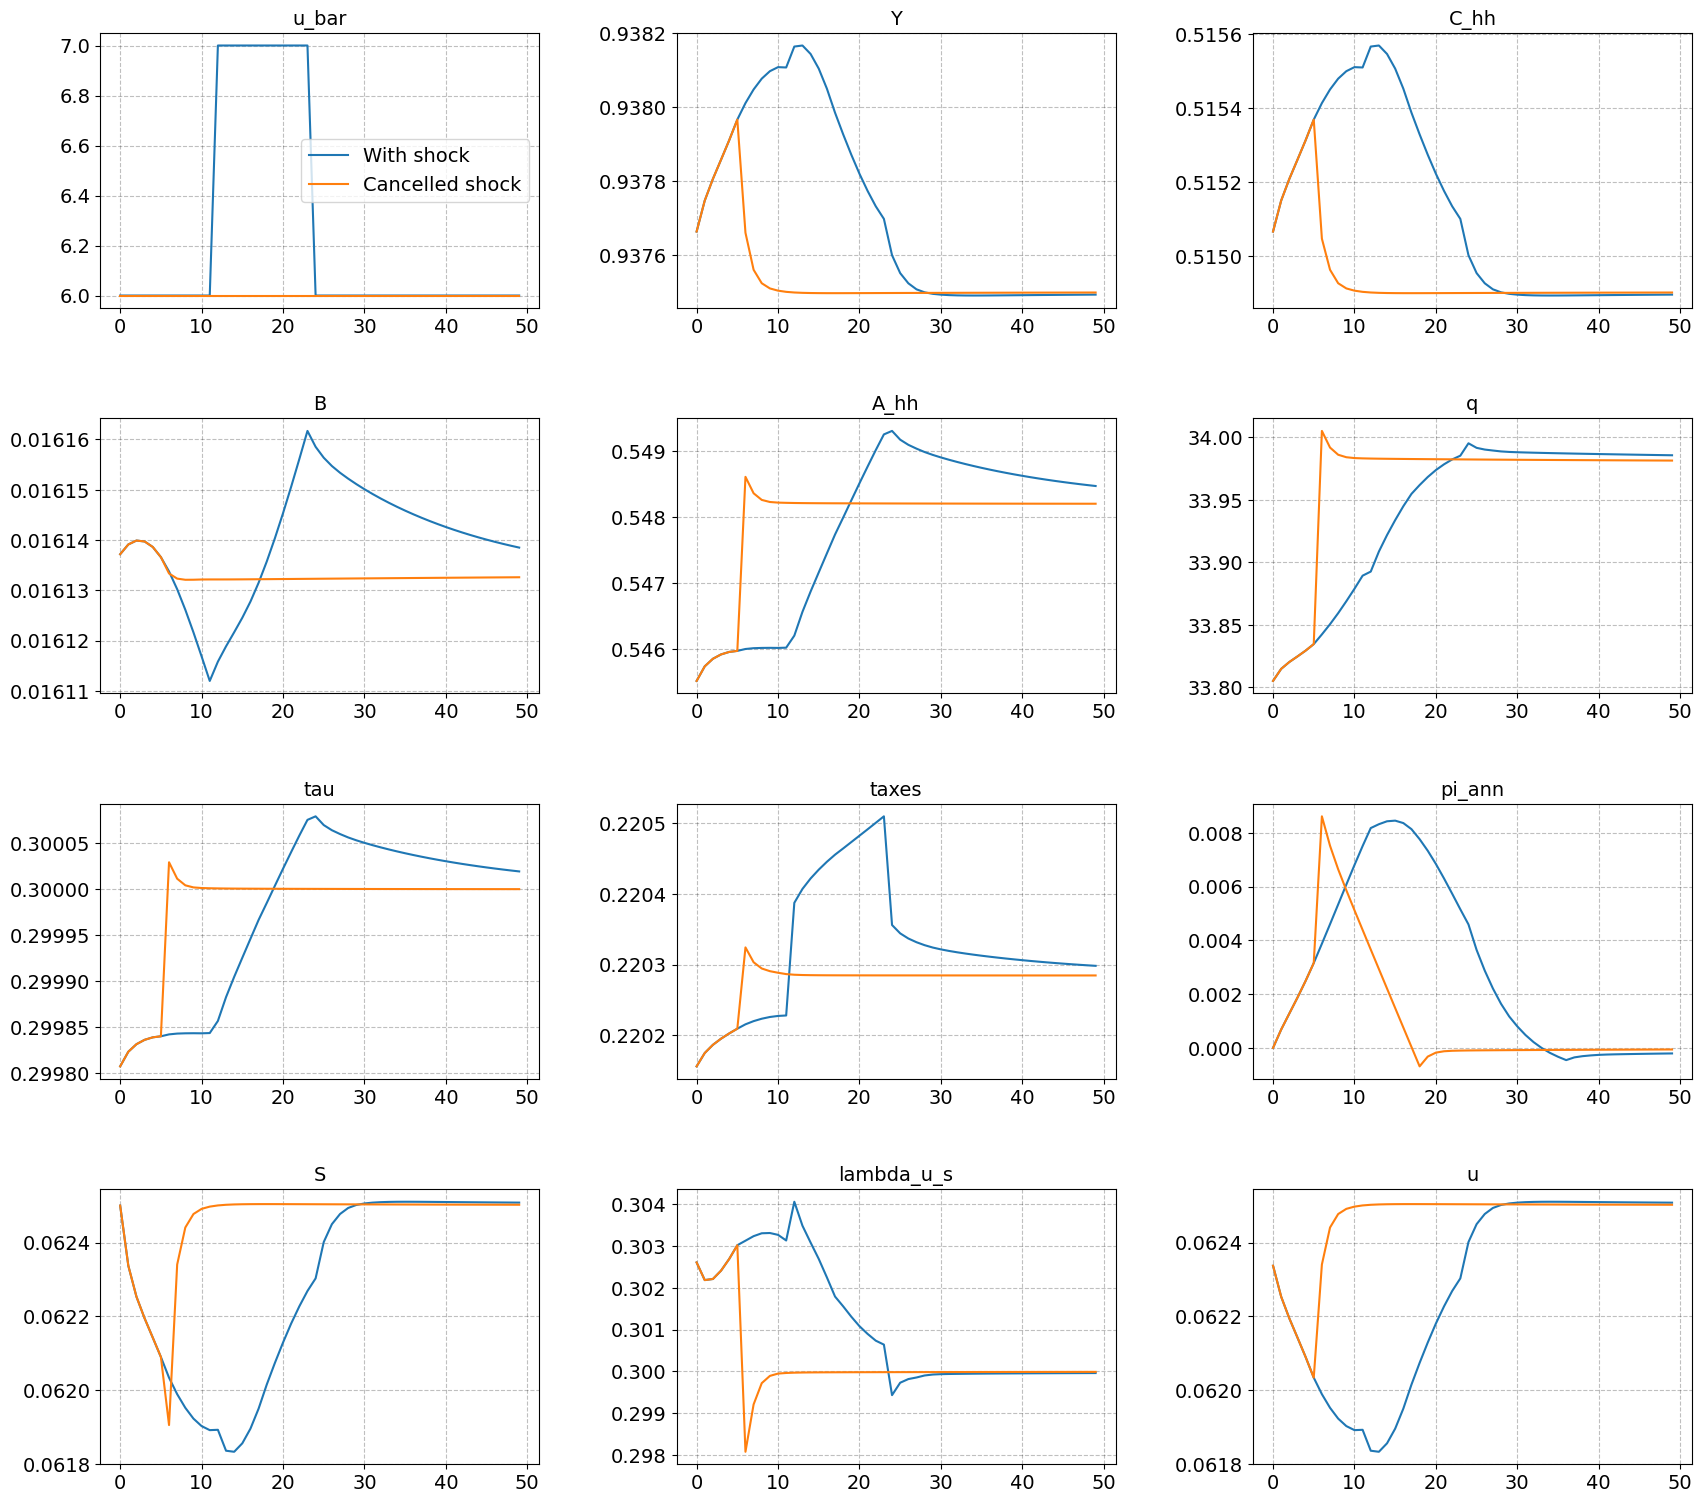

In [41]:
model.compare_IRFs(models=[modelVII,modelVIIb],labels=['With shock','Cancelled shock'],varnames=paths,abs_diff=abs_diff,lvl_value=lvl_value,T_max=50,ncols=3,do_targets=False,do_shocks=False,filename='figures/IRFs_du_bar_fake_shock')